# Тестовое задание 

   Ваша задача написать пайплайн для тренировки модели глубоко обучения (любую – **embeddings + LSTM, Bert** …) с использованием следующих инструментов: pytorch, sklearn, matplotlib – для решения задачи **NER** (извлечения сущностей).

   В качестве данных используется датасет **Conll2003** с четырьмя классами **Per, Org, Loc, Misc** в формате **Conll**.

   В тетрадке ниже заданы основные классы и функции для построения требуемого пайплайн, какие-то уже имплементированы, какие-то – нет. Их требуется доработать. Тем не менее если данный набор абстракций вам не подходит Вы можете написать свой пайплайн «с нуля», однако у этих действий должно быть обоснование.

**Что оценивается в первую очередь:**
- Выбранная архитектура для решения задачи (генеративная/экстрактивная)
- Выбранные предобученные веса 
- Полученные метрики
- Анализ ошибок модели

**Затем:**
- Глубина разведочного анализа (EDA)
- Испольуземые инстурменты для сравнения экспериментов
- Какая схема теггирования используется (**BIO, IO** или другие)
- Каким образом производится расчет метрик (потокенный отчет, отчет по точному совпадению спанов сущностей)

**С меньшим приоритетом:** 
- Скорость предобработки и постобработки данных 
- Стиль кода

In [1]:
# !wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa
# !wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testb
# !wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train

--2022-11-01 20:29:27--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 748096 (731K) [text/plain]
Saving to: ‘eng.testb’

eng.testb           100%[===================>] 730,56K  2,60MB/s    in 0,3s    

2022-11-01 20:29:28 (2,60 MB/s) - ‘eng.testb’ saved [748096/748096]



In [2]:
# !head eng.train 

In [1]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, accuracy_score, f1_score
from torch.utils.data import Dataset, DataLoader
from dataclasses import dataclass
from collections import Counter
from typing import List
from tqdm import tqdm
from torch import nn

import matplotlib.pyplot as plt
import pandas as pd
import datetime
import string
import wandb
import torch
import time
import os

/home/yurii/projects/NER/NER_venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configuration 

In [2]:
config = {
    'model_name': 'distilbert-base-cased',
    'num_expiriment': '2',
    'max_length': 256,
    'train_batch_size': 2,
    'eval_batch_size': 16,
    'num_epoch': 5,
    'learning_rate': 1e-5,
    'epsilon': 1e-6, 
    'warmup_steps': 1000,
    'weight_decay': 0.01
}

# Read data and clear data

In [3]:
# Tagging IOB to BIO conversion function
def IOB_2_BIO_tagging(tags: List[str]) -> List[str]:
    BIO_tags = []
    for i, tag in enumerate(tags):
        if tag.startswith('I') and (i == 0 or tags[i-1][1:] != tag[1:]):
            BIO_tags.append(f'B{tag[1:]}')
        else:
            BIO_tags.append(tag)
    return BIO_tags


# Testing
l_test = ['I-PER', 'B-PER', 'O', 'O', 'I-LOC', 'I-LOC', 'B-LOC', 'I-LOC', 'O', 'O', 'O']
r = IOB_2_BIO_tagging(l_test)
print(l_test)
print(r)

['I-PER', 'B-PER', 'O', 'O', 'I-LOC', 'I-LOC', 'B-LOC', 'I-LOC', 'O', 'O', 'O']
['B-PER', 'B-PER', 'O', 'O', 'B-LOC', 'I-LOC', 'B-LOC', 'I-LOC', 'O', 'O', 'O']


In [4]:
def read_data(file: os.PathLike):
    lines = open(file, "r").readlines()
    data = {"sentences": [], "labels": []}
    sentence, labels = [], []
    for line in tqdm(lines):
        line = line.strip()
        if not line:
            if sentence and labels:
                assert len(sentence) == len(labels)
                data["sentences"].append(' '.join(sentence))
                data["labels"].append(IOB_2_BIO_tagging(labels))
                sentence, labels = [], []
            continue
        if line.startswith("-DOCSTART-"):
            continue
        else:
            values = line.split(" ")
            try:
                token, _, _, label = values
                # Lower all sentece
                # sentence.append(token.lower())
                sentence.append(token)

                labels.append(label)
            except Exception as e:
                print(f"Error has occur: {e}")
                continue
    return data


train = read_data("eng.train")
valid = read_data("eng.testa")
test = read_data('eng.testb')

100%|██████████| 50351/50351 [00:00<00:00, 1013560.06it/s]


In [5]:
train_df = pd.DataFrame(train)
valid_df = pd.DataFrame(valid)
test_df = pd.DataFrame(test)

In [6]:
def text_without_letters(text: str) -> bool:
    for symbol in text:
        if symbol.isalpha():
            return False
    return True


def clear_df(df: pd.DataFrame) -> pd.DataFrame:
    df['labels'] = df['labels'].map(lambda labels: ' '.join(labels))

    df = df.drop_duplicates()
    df = df.drop_duplicates(subset=['sentences'], keep=False)
    df = df.drop(df[df['sentences'].map(text_without_letters)].index)
    df = df.reset_index(drop=True)

    df['labels'] = df['labels'].map(lambda labels: labels.split(' '))

    return df

In [7]:
train_df = clear_df(train_df)
valid_df = clear_df(valid_df)
test_df = clear_df(test_df)

In [8]:
train_df.head()

,sentences,labels
0,EU rejects German call to boycott British lamb .,"[B-ORG, O, B-MISC, O, O, O, B-MISC, O, O]"
1,Peter Blackburn,"[B-PER, I-PER]"
2,BRUSSELS 1996-08-22,"[B-LOC, O]"
3,The European Commission said on Thursday it di...,"[O, B-ORG, I-ORG, O, O, O, O, O, O, B-MISC, O,..."
4,Germany 's representative to the European Unio...,"[B-LOC, O, O, O, O, B-ORG, I-ORG, O, O, O, B-P..."


In [9]:
valid_df["sentences"][1], valid_df["labels"][1]

('LONDON 1996-08-30', ['B-LOC', 'O'])

# Data statistic

In [32]:
def visualize_distr(data: Counter):
    data = sorted(data.items())
    labels = list([elem[0] for elem in data])
    p = plt.bar(x=labels, height=[elem[1] for elem in data])
    
    sum_values = sum([elem[1] for elem in data])
    for rect1 in p:
        height = rect1.get_height()
        plt.annotate(
            f'{height}\n{height*100/sum_values:.1f}%', 
            (rect1.get_x() + rect1.get_width()/2, height+.05),
            ha="center", va="bottom", fontsize=12
        )

    plt.show()


def show_statistic(df: pd.DataFrame):
    
    NE_distribution = Counter()

    count_tokens = 0
    count_named_entities = 0
    for labels in df['labels']:
        count_tokens += len(labels)
        NE_labels = [label[2:] for label in labels if label != 'O']
        count_named_entities += len(NE_labels)
        NE_distribution.update(NE_labels)

    
    print(f'Count sentences: {df.shape[0]}')
    print(f'Count tokens: {count_tokens}')
    print(f'Count unnamed tokens: {count_tokens - count_named_entities} | {(count_tokens - count_named_entities) * 100 / count_tokens:.1f}%')
    print(f'Count named tokens (NE): {count_named_entities} | {count_named_entities * 100 / count_tokens:.1f}%')
    print('\nNamed tokens distribution')
    visualize_distr(NE_distribution)
    


Count sentences: 12511
Count tokens: 197066
Count unnamed tokens: 164770 | 83.6%
Count named tokens (NE): 32296 | 16.4%

Named tokens distribution


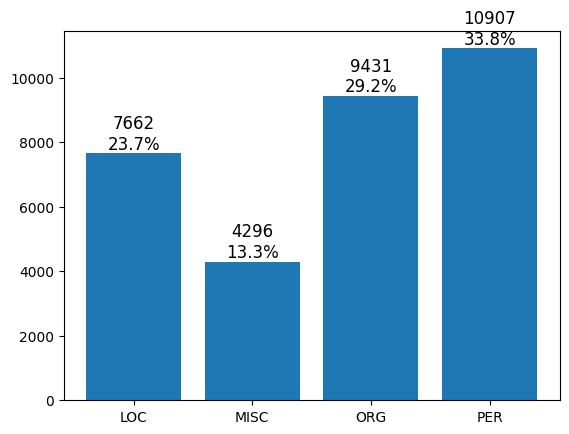

In [33]:
show_statistic(train_df)

Count sentences: 3040
Count tokens: 50653
Count unnamed tokens: 42261 | 83.4%
Count named tokens (NE): 8392 | 16.6%

Named tokens distribution


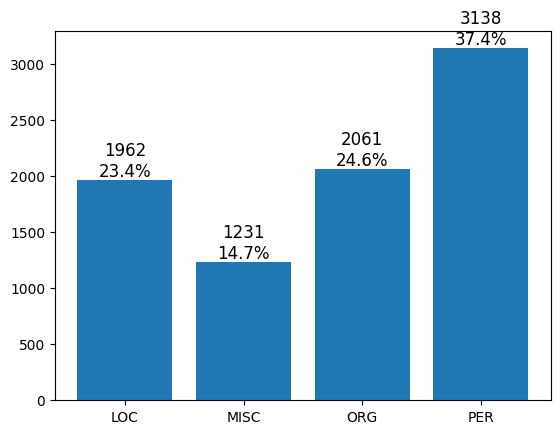

In [34]:
show_statistic(valid_df)

Count sentences: 3124
Count tokens: 45181
Count unnamed tokens: 37330 | 82.6%
Count named tokens (NE): 7851 | 17.4%

Named tokens distribution


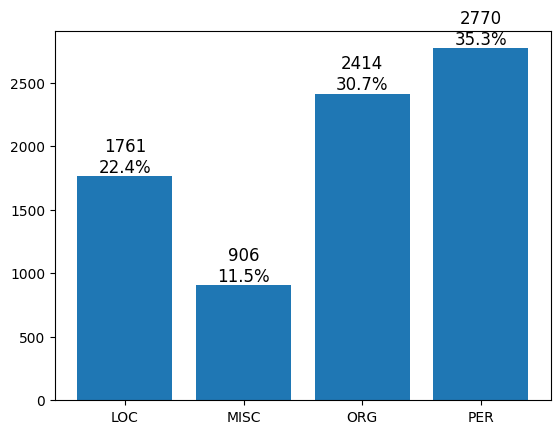

In [35]:
show_statistic(test_df)

In [36]:
ls_all_sentences = train_df['sentences'].values.tolist() + valid_df['sentences'].values.tolist() + test_df['sentences'].values.tolist()

In [37]:
count_lens = []

for sentence in ls_all_sentences:
    count_lens.append(len(sentence.split(' ')))

pd.DataFrame(count_lens).describe()

,0
count,18675.000000
mean,15.684070
std,11.812401
min,1.000000
25%,7.000000
50%,11.000000
75%,24.000000
max,124.000000


In [38]:
set_character_without_letters = set()

for sentence in ls_all_sentences:
    for character in sentence:
        if not (ord('A') <= ord(character) <= ord('Z') or
            ord('a') <= ord(character) <= ord('z') or
            ord('0') <= ord(character) <= ord('9') or
            ord(character) == ord(' ')
        ):
            set_character_without_letters.add(character)

set_character_without_letters

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '=',
 '?',
 '@',
 '[',
 ']',
 '`'}

In [39]:
set_punctuation = set(string.punctuation)
set_character_without_letters.issubset(set_punctuation)

True

In [40]:
set_punctuation = set(string.punctuation)
for sentence in ls_all_sentences:
    for word in sentence.split(' '):
        if len(word) > 1:
            for character in word:
                if character in set_punctuation:
                    print(word)
                    break

1996-08-22
's
's
n't
n't
's
EU-wide
--
's
's
's
re-examine
brain-wasting
's
47,600
4,275
17,000
1996-08-22
U.S.
17,000
's
10,925
16,935
n't
's
5,060
7,845
1996-08-22
's
...
's
's
's
's
14.2
1996-08-22
first-time
14.2
year-earlier
356,725
--
304,850
15,613
13.6
2.2
Motor-bike
32.7
77,719
49,269
16.4
35,563
11.7
's
3,420
's
1996-08-22
's
--
+301
3311812-4
C$
six-year
C$
6.625
24.SEP.02
100.92
24.SEP.96
1.875
99.32
+20
S&P
1-10-100
0.275
1.60
7.0
--
+44
floating-rate
12.5
21.JAN.99
S23.SEP.96
99.956
S&P
AA+
1-10-100
--
+44
--
1996-08-22
's
's
Ben-Elissar
right-wing
al-
Israeli-Syrian
's
...
...
's
's
's
1996-08-22
's
d'affaires
's
non-payment
1996-08-22
's
Secretary-General
's
's
U.S.-sponsored
U.S.-led
1996-08-22
3.7504
One-month
5-1/2
3/8
5-5/8
1/2
5-3/4
5/8
One-year
5-7/8
's
Israeli-PLO
's
's
right-wing
right-wing
's
1996-08-22
's
MiG-19
's
's
--
--
's
's
ultra-nationalist
's
U.N.
's
's
's
1996-08-22
AN-NAHAR
AS-SAFIR
..
AL-ANWAR
--
AD-DIYAR
NIDA'A
AL-WATAN
1996-08-22
0.200
0.100
cattl

In [41]:
count_upper_word = 0
count_total_words = 0

for sentence in ls_all_sentences:
    for word in sentence.split(' '):
        if word.isupper():
            count_upper_word += 1
        count_total_words += 1

print(f'Count words written in capital letters: {count_upper_word}')
print(f'Percentage of total words: {count_upper_word*100/count_total_words:.2f}%')

Count words written in capital letters: 10633
Percentage of total words: 3.63%


# Tokenization, create Datasets and Dataloaders

In [10]:
tokenizer = AutoTokenizer.from_pretrained(config['model_name'])

In [11]:
sentence = train_df['sentences'][4]

tokenized_text = tokenizer.encode_plus(
    sentence.split(),
    padding='max_length',
    max_length = 8,
    truncation=True,
    return_tensors="pt",
    is_split_into_words=True
)

print(sentence)
print(tokenized_text['input_ids'][0])
print(tokenizer.convert_ids_to_tokens(tokenized_text['input_ids'][0]))
print(tokenized_text.word_ids())

Germany 's representative to the European Union 's veterinary committee Werner Zwingmann said on Wednesday consumers should buy sheepmeat from countries other than Britain until the scientific advice was clearer .
tensor([ 101, 1860,  112,  188, 4702, 1106, 1103,  102])
['[CLS]', 'Germany', "'", 's', 'representative', 'to', 'the', '[SEP]']
[None, 0, 1, 1, 2, 3, 4, None]


In [12]:
label_to_id = {
    'O' : 0,
    'B-PER' : 1,
    'I-PER' : 2,
    'B-ORG' : 3,
    'I-ORG' : 4,
    'B-LOC' : 5,
    'I-LOC' : 6,
    'B-MISC' : 7,
    'I-MISC' : 8,
}

id_to_label = {v: k for k, v in label_to_id.items()}

In [13]:
class NERDataset(Dataset):

    @staticmethod
    def align_label_and_convert_to_ids(word_ids: List[int], labels: List[str]) -> List[str]:

        previous_word_idx = None
        aligned_labels = []

        for word_id in word_ids:

            if word_id is None or word_id == previous_word_idx:
                aligned_labels.append(-100)
            else:
                aligned_labels.append(label_to_id[labels[word_id]])
            
            previous_word_idx = word_id

        return aligned_labels

    def __init__(self, df: pd.DataFrame, tokenizer: AutoTokenizer, max_length: int):
        
        self.sentences = [
            tokenizer.encode_plus(
                sentence.split(),
                padding='max_length',
                max_length = max_length,
                truncation=True,
                return_tensors="pt",
                is_split_into_words=True
            )
            for sentence in df['sentences'].values.tolist()
        ]
        
        self.labels = [
            torch.tensor(
                NERDataset.align_label_and_convert_to_ids(self.sentences[i].word_ids(), labels) 
            )
            for i, labels in enumerate(df['labels'].values.tolist())
        ]

    def __getitem__(self, index: int):
        input_ids = self.sentences[index]['input_ids']
        mask  = self.sentences[index]['attention_mask']
        labels = self.labels[index]

        return input_ids, mask, labels

    def __len__(self):
        return len(self.labels)

In [14]:
train_dataset = NERDataset(train_df, tokenizer, config['max_length'])
valid_dataset = NERDataset(valid_df, tokenizer, config['max_length'])
test_dataset = NERDataset(test_df, tokenizer, config['max_length'])

In [15]:
train_dataset[0]

(tensor([[  101,  7270, 22961,  1528,  1840,  1106, 21423,  1418,  2495, 12913,
            119,   102,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,   

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=config['train_batch_size'], shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=config['eval_batch_size'], shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=config['eval_batch_size'], shuffle=True)

# Create model

In [17]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cuda', index=0)

In [18]:
model = AutoModelForTokenClassification.from_pretrained(config['model_name'], num_labels=len(label_to_id))
model = model.to(device)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForTokenClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this 

In [19]:
for name, param in model.state_dict().items():
    print(name, param.size())

distilbert.embeddings.word_embeddings.weight torch.Size([28996, 768])
distilbert.embeddings.position_embeddings.weight torch.Size([512, 768])
distilbert.embeddings.LayerNorm.weight torch.Size([768])
distilbert.embeddings.LayerNorm.bias torch.Size([768])
distilbert.transformer.layer.0.attention.q_lin.weight torch.Size([768, 768])
distilbert.transformer.layer.0.attention.q_lin.bias torch.Size([768])
distilbert.transformer.layer.0.attention.k_lin.weight torch.Size([768, 768])
distilbert.transformer.layer.0.attention.k_lin.bias torch.Size([768])
distilbert.transformer.layer.0.attention.v_lin.weight torch.Size([768, 768])
distilbert.transformer.layer.0.attention.v_lin.bias torch.Size([768])
distilbert.transformer.layer.0.attention.out_lin.weight torch.Size([768, 768])
distilbert.transformer.layer.0.attention.out_lin.bias torch.Size([768])
distilbert.transformer.layer.0.sa_layer_norm.weight torch.Size([768])
distilbert.transformer.layer.0.sa_layer_norm.bias torch.Size([768])
distilbert.trans

# Train and test model

In [20]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config['learning_rate'],
    eps=config['epsilon'],
    weight_decay=config['weight_decay']
)

In [21]:
total_steps = len(train_dataloader) * config['num_epoch']

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=config['warmup_steps'],
    num_training_steps=total_steps,
)

In [22]:
@dataclass
class SetMetrics:
    accuracy: float = None
    F1: float = None


def calculate_metrics(gold_labels_per_sentence: List[List[str]], predict_labels_per_sentence: List[List[str]]) -> SetMetrics:

    gold_labels = [l for l_per_sent in gold_labels_per_sentence for l in l_per_sent]
    predict_labels = [l for l_per_sent in predict_labels_per_sentence for l in l_per_sent]

    return SetMetrics(
        accuracy=accuracy_score(gold_labels, predict_labels),
        F1=f1_score(gold_labels, predict_labels, average='macro'),
    )


def print_metrics(gold_labels_per_sentence: List[List[str]], predict_labels_per_sentence: List[List[str]]) -> SetMetrics:

    gold_labels = [l for l_per_sent in gold_labels_per_sentence for l in l_per_sent]
    predict_labels = [l for l_per_sent in predict_labels_per_sentence for l in l_per_sent]

    print(classification_report(gold_labels, predict_labels))

In [23]:
wandb.init(
    project='NER_test_task_ZERO',
    entity="ur_or",
    name=f'fine-tune_{config["model_name"]}{config["num_expiriment"]}',
    config={
        'learning_rate': config['learning_rate'],
        'architecture': 'BertForTokenClassification',
        'epochs': config['num_epoch'],
        'batch_size': config['train_batch_size'],
        'max_seq_length': config['max_length'],
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Currently logged in as: ur_or. Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [24]:
def format_time(seconds: float) -> str:
    # Format time from seconds to hh:mm:ss format
    return str(datetime.timedelta(seconds=seconds))

In [25]:
total_t0 = time.perf_counter()

for epoch in range(1, config['num_epoch'] + 1):

    print(f'======== Epoch {epoch} / {config["num_epoch"]} ========')
    print('Training...')

    t0 = time.perf_counter()
    total_train_loss = 0
    model.train()

    for step, train_batch in enumerate(train_dataloader):

        if step % 100 == 0 and not step == 0:
            elapsed = format_time(time.perf_counter() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Elapsed: {elapsed}.')
            wandb.log({'learning_rate': scheduler.get_last_lr()[0]})

        b_input_ids = train_batch[0].squeeze(1).to(device)
        b_mask = train_batch[1].squeeze(1).to(device)
        b_labels = train_batch[2].to(device)

        optimizer.zero_grad()
        loss, logits = model(
            input_ids=b_input_ids,
            attention_mask=b_mask,
            labels=b_labels,
            return_dict=False
        )
        
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()

        wandb.log({'train_loss': loss})

    avg_train_loss = total_train_loss/ len(train_dataloader)

    training_time = format_time(time.perf_counter() - t0)

    print(f'Average training loss: {avg_train_loss:.3f}')
    print(f'Training epcoh took: {training_time}')

    # Validation

    print('Running Validation...')

    t0 = time.perf_counter()
    total_eval_loss = 0
    model.eval()

    predict_labels, gold_labels = [], []

    for valid_batch in valid_dataloader:

        b_input_ids = valid_batch[0].squeeze(1).to(device)
        b_mask = valid_batch[1].squeeze(1).to(device)
        b_labels = valid_batch[2].to(device)

        with torch.no_grad():
            loss, logits = model(
                input_ids=b_input_ids,
                attention_mask=b_mask,
                labels=b_labels,
                return_dict=False
            )

        total_eval_loss += loss.item()

        for i in range(logits.shape[0]):

            logits_clean = logits[i][b_labels[i] != -100]
            probabilities = torch.nn.functional.softmax(logits_clean, dim=1)
            predictions = probabilities.argmax(dim=1)

            label_clean = b_labels[i][b_labels[i] != -100]
            
            gold_labels.append(label_clean.to('cpu'))
            predict_labels.append(predictions.to('cpu'))

    avg_val_loss = total_eval_loss / len(valid_dataloader)
    validation_time = format_time(time.perf_counter() - t0)

    print_metrics(gold_labels, predict_labels)
    print(f' Validation Loss: {avg_val_loss:.3f}')
    print(f' Validation took: {validation_time}')

    valid_metrics = calculate_metrics(gold_labels, predict_labels)
    wandb.log({
        'epoch': epoch,
        'time': training_time + validation_time,
        'avg_train_loss': avg_train_loss,
        'avg_valid_loss': avg_val_loss,
        'valid_acc': valid_metrics.accuracy,
        'valid_F1': valid_metrics.F1,        
    })


======== Epoch 1 / 5 ========
Training...
Batch 100 of 6256. Elapsed: 0:00:04.078522.
Batch 200 of 6256. Elapsed: 0:00:07.492397.
Batch 300 of 6256. Elapsed: 0:00:10.975226.
Batch 400 of 6256. Elapsed: 0:00:14.598521.
Batch 500 of 6256. Elapsed: 0:00:18.180408.
Batch 600 of 6256. Elapsed: 0:00:21.733207.
Batch 700 of 6256. Elapsed: 0:00:25.272311.
Batch 800 of 6256. Elapsed: 0:00:28.814332.
Batch 900 of 6256. Elapsed: 0:00:32.339654.
Batch 1000 of 6256. Elapsed: 0:00:35.887624.
Batch 1100 of 6256. Elapsed: 0:00:39.323177.
Batch 1200 of 6256. Elapsed: 0:00:42.752987.
Batch 1300 of 6256. Elapsed: 0:00:46.292588.
Batch 1400 of 6256. Elapsed: 0:00:49.983633.
Batch 1500 of 6256. Elapsed: 0:00:53.743889.
Batch 1600 of 6256. Elapsed: 0:00:57.344703.
Batch 1700 of 6256. Elapsed: 0:01:00.976882.
Batch 1800 of 6256. Elapsed: 0:01:04.526189.
Batch 1900 of 6256. Elapsed: 0:01:08.010213.
Batch 2000 of 6256. Elapsed: 0:01:11.553156.
Batch 2100 of 6256. Elapsed: 0:01:15.286468.
Batch 2200 of 6256. El

In [26]:
print(f'Predicting labels for {len(test_dataloader.dataset)} test sentences...')

model.eval()

predict_labels, gold_labels = [], []

for test_batch in test_dataloader:

    b_input_ids = test_batch[0].squeeze(1).to(device)
    b_mask = test_batch[1].squeeze(1).to(device)
    b_labels = test_batch[2].to(device)

    with torch.no_grad():
        loss, logits = model(
            input_ids=b_input_ids,
            attention_mask=b_mask,
            labels=b_labels,
            return_dict=False
        )

    total_eval_loss += loss.item()

    for i in range(logits.shape[0]):

        logits_clean = logits[i][b_labels[i] != -100]
        probabilities = torch.nn.functional.softmax(logits_clean, dim=1)
        predictions = probabilities.argmax(dim=1)

        label_clean = b_labels[i][b_labels[i] != -100]
        
        gold_labels.append(label_clean.to('cpu'))
        predict_labels.append(predictions.to('cpu'))


metrics = calculate_metrics(gold_labels, predict_labels)

print('Relust test metrics:')
print(f'Accuracy: {metrics.accuracy:.3f}')
print(f'F1: {metrics.F1:.3f}')

wandb.log({
    'test_acc': metrics.accuracy,
    'test_F1': metrics.F1,
})

print('DONE!')

Predicting labels for 3124 test sentences...
Relust test metrics:
Accuracy: 0.980
F1: 0.888
DONE!


In [27]:
def save_trained_model(model: AutoModelForTokenClassification, output_dir: os.PathLike, tokenizer: AutoTokenizer):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print(f'Saving model to {output_dir}')

    model_to_save = model.module if hasattr(model, 'module') else model
    model_to_save.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

In [28]:
output_dir=f'model_outputs/finetuned-{config["model_name"]}{config["num_expiriment"]}/'

save_trained_model(model, output_dir, tokenizer)

Saving model to model_outputs/finetuned-distilbert-base-cased2/


# Inference model

In [29]:
class NER_markuper():

    @staticmethod
    def align_label(word_ids: List[int], labels: List[str]) -> List[str]:

        previous_word_idx = None
        aligned_labels = []

        for word_id in word_ids:

            if word_id is None or word_id == previous_word_idx:
                aligned_labels.append(-100)
            else:
                aligned_labels.append(labels[word_id])
            
            previous_word_idx = word_id

        return aligned_labels


    def __init__(self, model, tokenizer):
        self.__tokenizer = tokenizer
        self.__model = model
        self.__model.eval()

 
    def markup_entities(self, sentence: str) -> List[str]:

        # sentence = sentence.lower()
        encoded_dict = self.__tokenizer.encode_plus(
            sentence.split(),
            padding='max_length',
            max_length = config['max_length'],
            truncation=True,
            return_tensors="pt",
            is_split_into_words=True
        )

        input_id = encoded_dict['input_ids'].to(device)
        mask = encoded_dict['attention_mask'].to(device)

        mask_for_labels = [1] * len(sentence.split())
        
        mask_for_labels = torch.tensor(NER_markuper.align_label(encoded_dict.word_ids(), mask_for_labels))
        
        with torch.no_grad():
            logits = self.__model(
                input_ids=input_id,
                attention_mask=mask,
                labels=None,
                return_dict=False
            )
            
        logits_clean = logits[0][0][mask_for_labels != -100]

        probabilities = torch.nn.functional.softmax(logits_clean, dim=1)
        predictions = probabilities.argmax(dim=1).tolist()
        
        prediction_label = [id_to_label[i] for i in predictions]

        print(probabilities)
        print(predictions)
        print(sentence)
        print(prediction_label)

In [30]:
res_markuper = NER_markuper(model, tokenizer)

In [31]:
res_markuper.markup_entities('Japan began the defence of their Asian Cup title with a lucky 2-1 win against Syria in a Group C championship match on Friday.')

tensor([[1.6383e-05, 3.7909e-05, 3.7130e-05, 5.0446e-05, 1.3423e-05, 9.9974e-01,
         8.4226e-05, 1.9091e-05, 5.6559e-06],
        [9.9997e-01, 3.9404e-06, 2.1217e-06, 5.3533e-06, 3.1542e-06, 4.2423e-06,
         3.7671e-06, 5.0233e-06, 2.4325e-06],
        [9.9996e-01, 6.3142e-06, 2.6859e-06, 7.6526e-06, 3.1041e-06, 4.7554e-06,
         4.4593e-06, 7.5353e-06, 2.5192e-06],
        [9.9995e-01, 5.1582e-06, 2.5860e-06, 1.1770e-05, 3.2949e-06, 4.0971e-06,
         4.1223e-06, 9.6242e-06, 5.7603e-06],
        [9.9996e-01, 5.5106e-06, 2.2842e-06, 7.8872e-06, 3.3007e-06, 3.1735e-06,
         4.4738e-06, 1.2252e-05, 4.5738e-06],
        [9.9993e-01, 3.8914e-06, 3.0784e-06, 1.2394e-05, 3.3001e-06, 4.5185e-06,
         5.1645e-06, 3.1062e-05, 3.8507e-06],
        [5.6059e-05, 6.1133e-05, 1.7912e-05, 5.5489e-04, 6.6620e-06, 1.4036e-04,
         2.9412e-05, 9.9800e-01, 1.1310e-03],
        [7.2223e-05, 1.1986e-04, 5.9360e-05, 2.2190e-05, 2.1453e-04, 1.2724e-05,
         2.4157e-04, 1.1097e-0